In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
from qick import *
from pickle_parser import *
import Pyro4
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [3]:
from phase_calibration import *

In [4]:
res = []
freqs = np.arange(1, 501, 1)
config = {"reps": 1}
# freqs=[60]
for freq in freqs:
    config['pulse_freq'] = freq
    prog = CalibratePhase(soccfg, config)
    data = prog.acquire_decimated(soc, progress=False)
    res.append([prog.calculate_phase(d) for d in data])
    soc.reset_gens()

sync = {}
for i in range(len(freqs)):
    print(freqs[i], (res[i][0][0] - res[i][1][0])%360)
    sync[freqs[i]] = (res[i][0][0] - res[i][1][0]) % 360

# print(prog)
# print(data)
# print(sync)

1 1.0849789361503213
2 1.6958128920347235
3 2.857766171568983
4 3.222414270215893
5 3.307053310197773
6 3.3810023241072145
7 3.4177776686536845
8 3.7009981926438513
9 4.038464731255829
10 4.2371801617306915
11 4.529503322656581
12 4.899524656769074
13 5.266280796810719
14 5.5860627086462955
15 6.009125340616265
16 6.353400703663738
17 6.729271290921645
18 7.050970834403728
19 7.388594868636915
20 7.7452811840451545
21 8.141008653704091
22 8.539405618317403
23 8.876491687412738
24 9.192496586247103
25 9.599279463820608
26 9.938572973439932
27 10.303405944638996
28 10.595835077331571
29 10.995084640569587
30 11.379785901085086
31 11.678767074016378
32 12.109973142050421
33 12.346828595598424
34 12.75692479939272
35 13.09884978315165
36 13.482024087537013
37 13.770383477640564
38 14.092244098456149
39 14.472716900364844
40 14.79371570689051
41 15.201345002239748
42 15.512732757814717
43 15.783951443922206
44 16.198934965658225
45 16.56585492207188
46 16.914317766125265
47 17.1940827940609

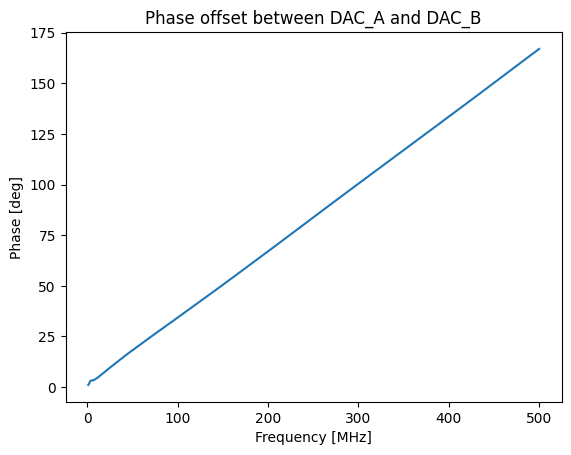

In [8]:
x = list(sync.keys())
y = list(sync.values())
plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [6]:
freq = 12

phi = sync[freq]-360*freq*35e-5
phases = [phi, 0]
print(freq,phi)

prog = QickProgram(soccfg) # Create program object
gains = [20000,20000]
for ch in range(2):
    prog.declare_gen(ch=ch, nqz=1)
    prog.trigger(pins=[0]) # send a pulse on pmod0_0, for scope trigger
    prog.set_pulse_registers(ch=ch, gain=gains[ch], freq=prog.freq2reg(freq), phase=prog.deg2reg(phases[ch], gen_ch=ch), style="const", length= prog.us2cycles(10, gen_ch=ch))
    prog.pulse(ch=ch, t=0)
prog.wait_all()
prog.end()

prog.config_all(soc) # Load assembly to board
soc.tproc.start() # Run program
# print(prog)

12 3.387524656769074
